In [11]:
print('hello')

hello


In [12]:
import pandas as pd
import datetime as dt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px


In [13]:
import chardet

# look at the first 100k bytes to guess the character encoding
with open("Sample-Superstore.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

# check what the character encoding might be
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [14]:
superstore = pd.read_csv('Sample-Superstore.csv', encoding='latin1')

In [15]:
# Inspect the dataset
print(superstore.head())
print(superstore.info())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

In [16]:
# Check for duplicate rows
duplicate_rows = superstore.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Optionally, display the duplicate rows
if duplicate_rows.sum() > 0:
    print(superstore[duplicate_rows])

Number of duplicate rows: 0


# Calculate Recency, Frequency and Monetary columns

In [17]:
# Convert Order Date to datetime
superstore['Order Date'] = pd.to_datetime(superstore['Order Date'])

In [18]:
# Define the reference date as the day after the last order date
reference_date = superstore['Order Date'].max() + dt.timedelta(days=1)

In [19]:
# Create RFM table
rfm_table = superstore.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,
    'Order ID': 'count',
    'Sales': 'sum'
}).reset_index()

In [20]:
# Rename columns
rfm_table.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

In [21]:

# Inspect RFM table
print(rfm_table.head())

  Customer ID  Recency  Frequency  Monetary
0    AA-10315      185         11  5563.560
1    AA-10375       20         15  1056.390
2    AA-10480      260         12  1790.512
3    AA-10645       56         18  5086.935
4    AB-10015      416          6   886.156


## Checking for Outliers

In [22]:
# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [23]:
# Detect outliers in each RFM metric
recency_outliers = detect_outliers(rfm_table, 'Recency')
frequency_outliers = detect_outliers(rfm_table, 'Frequency')
monetary_outliers = detect_outliers(rfm_table, 'Monetary')

In [24]:
# Print outliers
print(f"Recency Outliers:\n{recency_outliers}")
print(f"Frequency Outliers:\n{frequency_outliers}")
print(f"Monetary Outliers:\n{monetary_outliers}")

Recency Outliers:
    Customer ID  Recency  Frequency  Monetary
4      AB-10015      416          6   886.156
17     AF-10885      416          7   861.565
23     AG-10525      846          9  1455.038
42     AO-10810      502          1   161.280
49     AR-10570      535          2    88.150
..          ...      ...        ...       ...
728    SW-20755      535          8   758.696
735    TB-21280      584         11  2198.450
761    TS-21160      505         17  2163.624
776    VD-21670      582         16  6442.254
785    VT-21700     1001          9  1736.596

[74 rows x 4 columns]
Frequency Outliers:
    Customer ID  Recency  Frequency    Monetary
44     AP-10915       99         31   3323.5560
92     BM-11650       34         29   7294.1850
147    CK-12205       40         32   3154.8550
244    Dp-13240       85         29   7198.7610
257    EH-13765      136         32  10310.8800
275    EP-13915       13         31   5478.0608
311    GT-14710       37         29  11820.1200
349

In [25]:
# Remove outliers
rfm_table_no_outliers = rfm_table[~rfm_table['Customer ID'].isin(recency_outliers['Customer ID'])]
rfm_table_no_outliers = rfm_table_no_outliers[~rfm_table_no_outliers['Customer ID'].isin(frequency_outliers['Customer ID'])]
rfm_table_no_outliers = rfm_table_no_outliers[~rfm_table_no_outliers['Customer ID'].isin(monetary_outliers['Customer ID'])]


In [26]:
rfm_table_no_outliers.head(3)

,Customer ID,Recency,Frequency,Monetary
0,AA-10315,185,11,5563.560
1,AA-10375,20,15,1056.390
2,AA-10480,260,12,1790.512


In [27]:
rfm_table_no_outliers.shape

(668, 4)

## Scaling

In [28]:
# Normalize RFM values
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_table_no_outliers[['Recency', 'Frequency', 'Monetary']])


In [29]:
print(rfm_normalized)

[[ 0.87601203 -0.26167684  1.81572328]
 [-0.81270431  0.47200681 -0.86355737]
 [ 1.64361036 -0.07825593 -0.42715961]
 ...
 [-0.96622398 -0.81193958  1.75080356]
 [-0.91505076 -0.07825593  2.50343129]
 [ 1.06023563 -0.62851866 -0.60345403]]


# The Model

## Determin the optimal number of clusters using the elbow method

In [30]:
from sklearn.metrics import silhouette_score

c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 2, the average silhouette_score is : 0.34005137139841324


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 3, the average silhouette_score is : 0.3636009893886577


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 4, the average silhouette_score is : 0.31752988413728256


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 5, the average silhouette_score is : 0.33063009448862174


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 6, the average silhouette_score is : 0.2777403434068756


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 7, the average silhouette_score is : 0.2754018160843697


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 8, the average silhouette_score is : 0.28103657973130614


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 9, the average silhouette_score is : 0.27579763430943033


c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 10, the average silhouette_score is : 0.27276535574193206


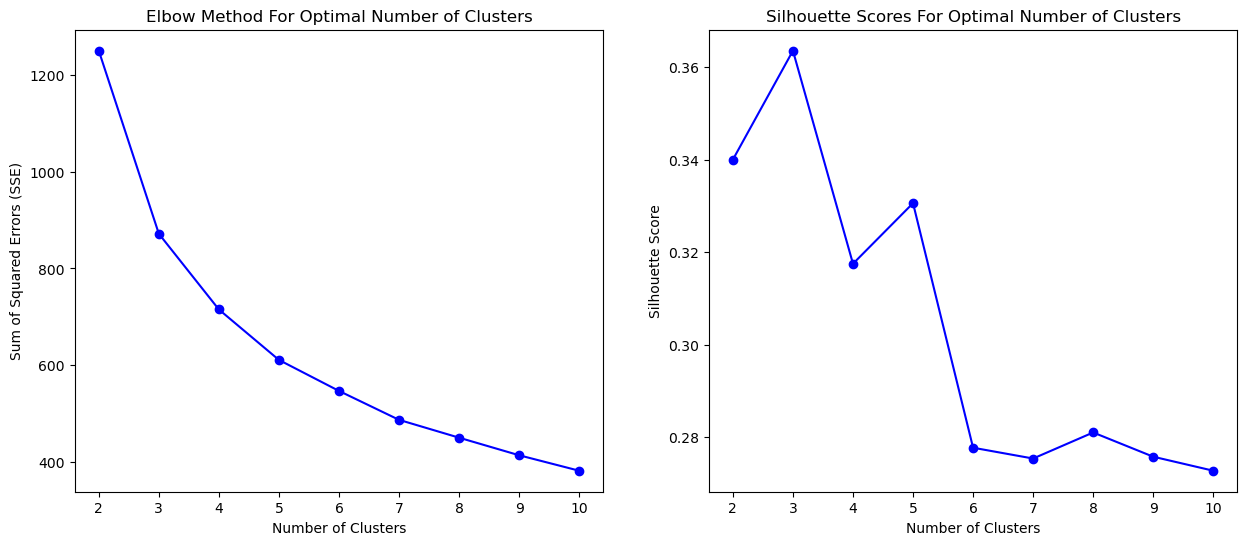

In [31]:
# Determine the optimal number of clusters using the elbow method and silhouette score
sse = {}
silhouette_scores = []
range_n_clusters = list(range(2, 11))

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_
    silhouette_avg = silhouette_score(rfm_normalized, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

# Plot the elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow Method
ax1.plot(list(sse.keys()), list(sse.values()), 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Sum of Squared Errors (SSE)')
ax1.set_title('Elbow Method For Optimal Number of Clusters')

# Silhouette Scores
ax2.plot(range_n_clusters, silhouette_scores, 'bo-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores For Optimal Number of Clusters')

plt.show()

In [32]:
# we determine that 3 is the best choice

In [33]:
k_optimal=3

## Fit the model

In [34]:
kmeans = KMeans(n_clusters=k_optimal, random_state=42)

In [35]:
rfm_table_no_outliers['Cluster'] = kmeans.fit_predict(rfm_normalized)

c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabb_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


<Axes: xlabel='Cluster', ylabel='Monetary'>

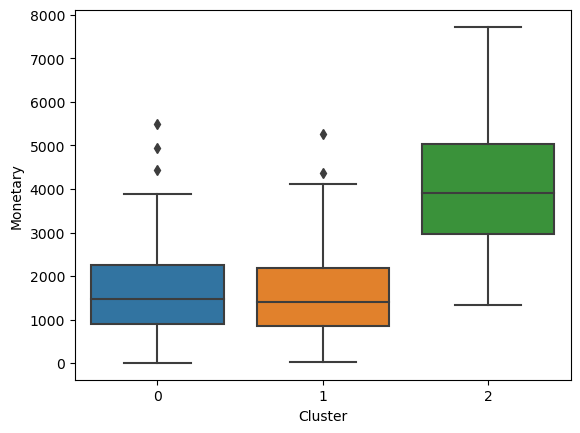

In [36]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster', y='Monetary', data=rfm_table_no_outliers)

<Axes: xlabel='Cluster', ylabel='Frequency'>

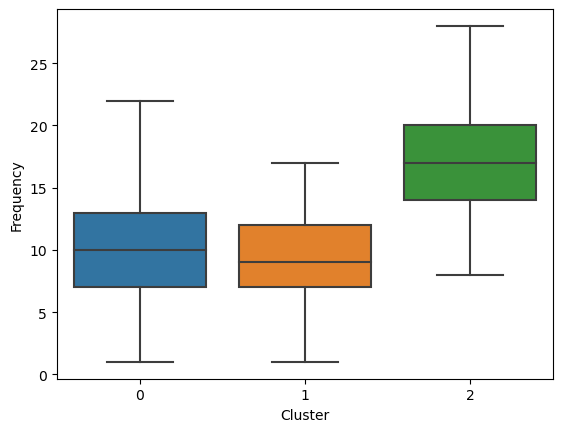

In [37]:

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster', y='Frequency', data=rfm_table_no_outliers)

<Axes: xlabel='Cluster', ylabel='Recency'>

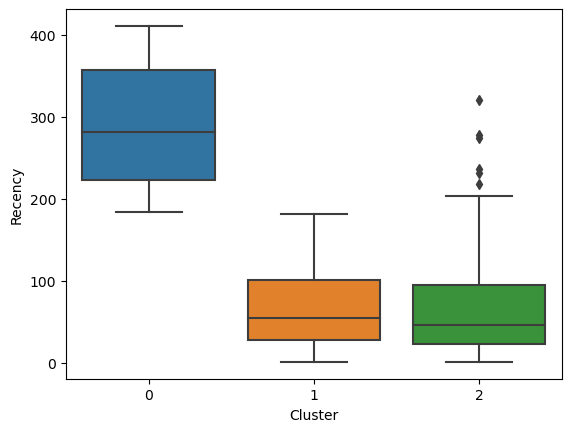

In [38]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster', y='Recency', data=rfm_table_no_outliers)

In [39]:
rfm_table_no_outliers.head(3)
rfm_analysis=rfm_table_no_outliers[['Frequency', 'Recency', 'Cluster', 'Monetary']]

## Analyse the clusters

In [40]:
cluster_analysis = rfm_analysis.groupby('Cluster').mean().reset_index()
print(cluster_analysis)

   Cluster  Frequency     Recency     Monetary
0        0   9.735294  287.774510  1619.724369
1        1   9.365079   65.431746  1537.869428
2        2  17.362550   65.498008  4089.376794


c:\Users\gabb_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


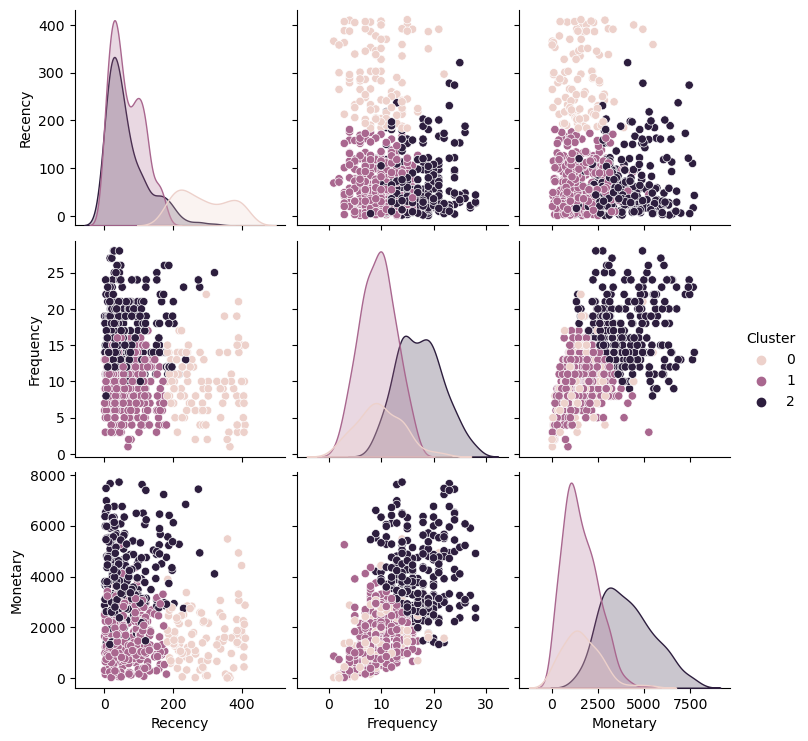

In [41]:
# Visualize clusters
sns.pairplot(rfm_table_no_outliers, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'])
plt.show()

In [42]:
#Optional clusters:
#Summary of Clusters:
#Loyal Customers: Frequent, recent purchasers who spend a lot.
#At-Risk Customers: Past big spenders who haven’t purchased recently.
#New Customers: Recent purchasers with few transactions and moderate spending.
#Potential Loyalists: Recent, occasional purchasers with moderate spending.
#Big Spenders: Customers who spend a lot but may not be frequent or recent.
#Lost Customers: Infrequent purchasers who haven’t bought anything in a long time and spend little.

In [52]:
# 3D Scatter Plot using Plotly Express for k=2 with customizations
fig = px.scatter_3d(rfm_table_no_outliers, x='Recency', y='Frequency', z='Monetary', color='Cluster',
                    title=f'3D Scatter Plot of Recency Frequency Monetary',
                    hover_data=['Customer ID', 'Recency', 'Frequency', 'Monetary'],
                    color_continuous_scale=['violet', 'white', 'green'])

# Update layout for background color and marker properties
fig.update_layout(
    scene=dict(
        xaxis=dict(backgroundcolor="black"),
        yaxis=dict(backgroundcolor="black"),
        zaxis=dict(backgroundcolor="black"),
    ),
    paper_bgcolor="black",
    plot_bgcolor="black",
    font=dict(color='white'),
    width=1200,  # Increase width
    height=800  # Increase height
)

# Update marker properties
fig.update_traces(marker=dict(size=5, opacity=0.6))

# Show the plot
fig.show()